### Visualizing NeuroTycho monkey anesthesia SCV results

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/Lauren/Voytek/spectralCV')
sys.path.append('/Users/rdgao/Documents/code/research/spectralCV')
sys.path.append('/Users/rdgao/Documents/code/research/neurodsp/')
sys.path.append('/Users/rdgao/Documents/code/research/fooof/')

%matplotlib inline

# imports
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']
import os

import neurodsp as ndsp
from fooof import FOOOFGroup
from scv_funcs import lfpca
from scv_funcs import utils
from scv_funcs import access_nt as asc

In [3]:
#data_path ="/Users/Lauren/Data/NeuroTycho/anesthesia/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/Session%d/"
data_path ="/Users/rdgao/Documents/data/NeuroTycho/Propofol/20120730PF_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_ECoG128/Session%d/"
saveout_path = "../results/nt/"
lfpca_files = sorted([f for f in os.listdir(saveout_path) if 'lfpca' in f])
fooof_files = sorted([f for f in os.listdir(saveout_path) if 'fooof' in f])

# visualizing SCV/Exponential fitness under different brain states

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


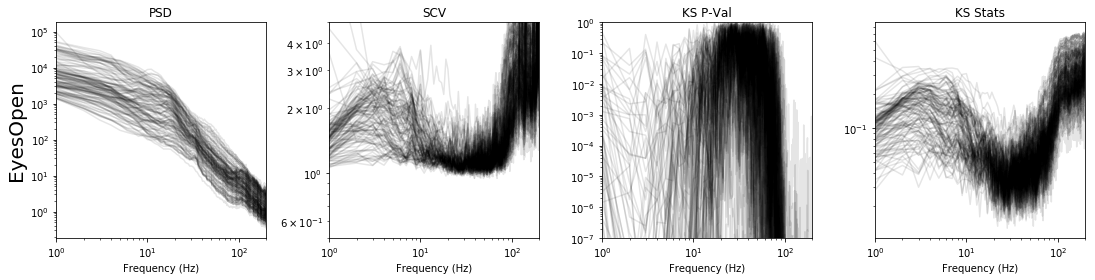

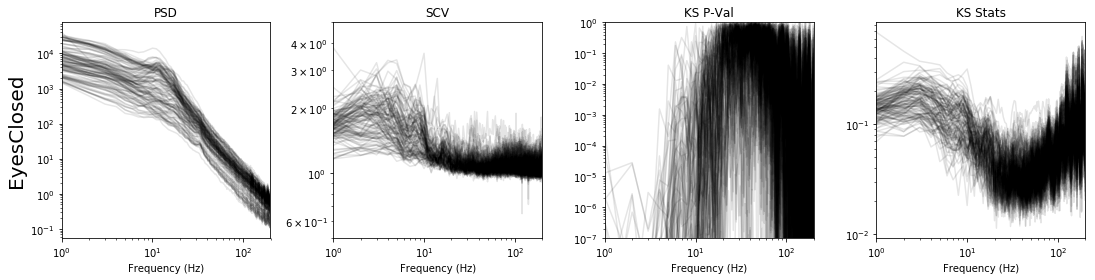

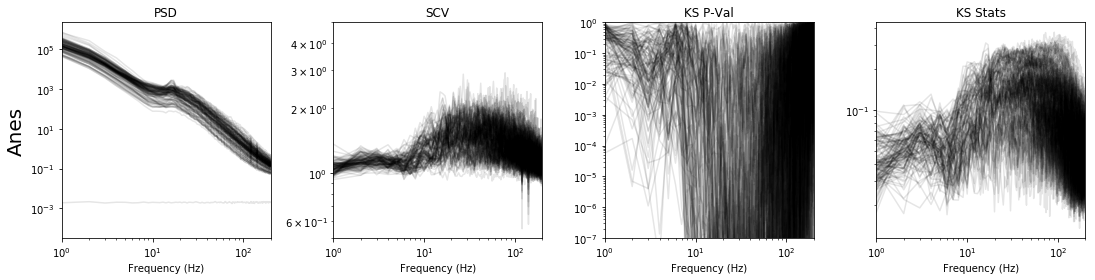

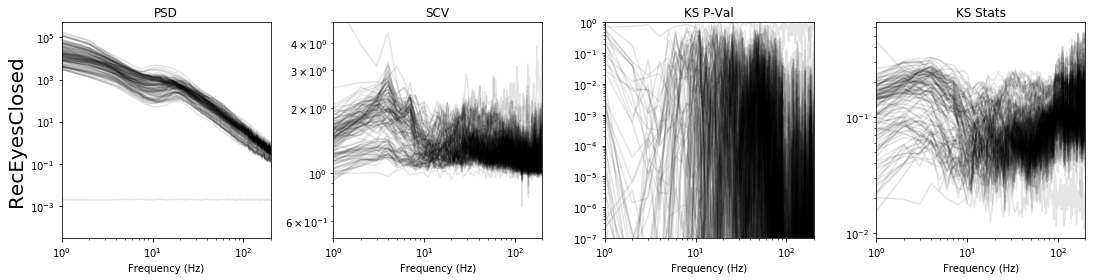

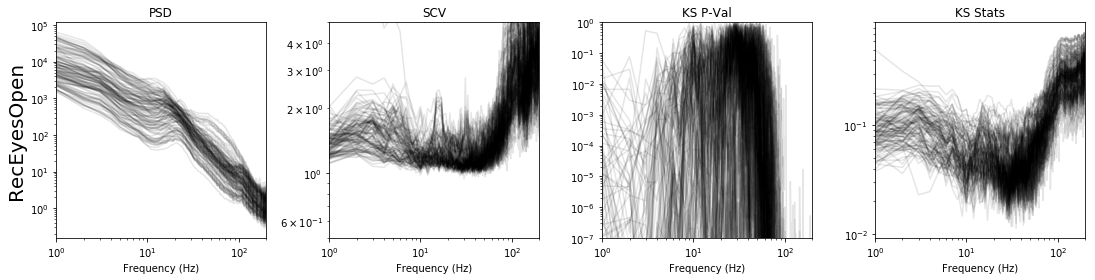

In [4]:
lfpca_all = []
for f in range(len(lfpca_files)):
    nt_lfpca = lfpca.lfpca_load_spec(saveout_path+lfpca_files[f])
    lfpca_all.append(nt_lfpca)
    plt.figure(figsize=(15,4))
    nt_lfpca.plot_spectral(plot_mean=False)
    plt.subplot(1,4,1)
    plt.ylabel(lfpca_files[f][10:-4], fontsize=20)


### observations: state-dependent changes in SCV
- resting and recovery periods have qualitatively similar SCVs and PSDs, with the exception of some oscillations
- in all but ANES conditions, low and high frequencies exhibit burst-like behavior, and the middle range (30-70Hz) is noise-like. This is the opposite for the anesthesia condition, where the middle range has higher variability than predicted
- it's possible that the anesthesia state is actually non-stationary, i.e. entering vs. maintenance of deep anesthesia. Should look into the temporal dynamics.

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


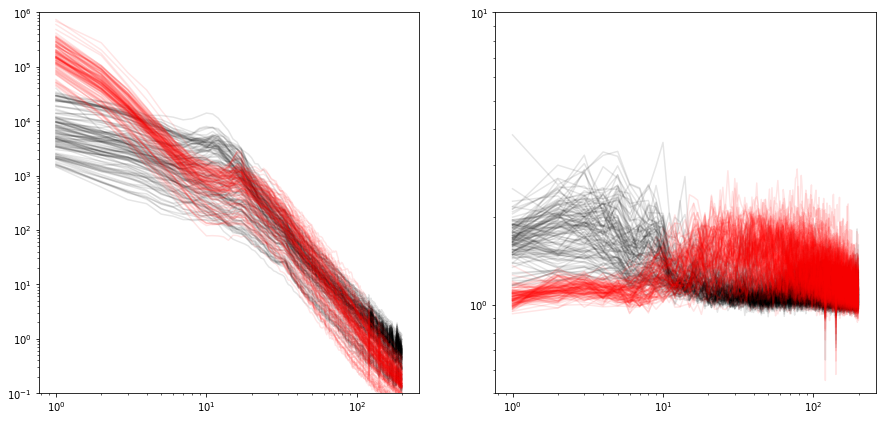

In [5]:
plot_conds = [1,2]
plot_colors = ['k', 'r', 'b']
plt.figure(figsize=(15,7))
for i, cond in enumerate(plot_conds):
    plt.subplot(1,2,1)
    plt.loglog(lfpca_all[cond].f_axis, lfpca_all[cond].psd.T, color=plot_colors[i], alpha=0.1)
    plt.ylim([1e-1, 1e6])
    plt.subplot(1,2,2)
    plt.loglog(lfpca_all[cond].f_axis, lfpca_all[cond].scv.T, color=plot_colors[i], alpha=0.1)
    plt.ylim([0.5, 10])
    plt.legend()


### observations: eyes closed (black) vs. anesthesia (red)
- PSDs, especially in the mid-frequency region, do not appear to change dramatically between eyes closed resting to anesthesia. However, there is a significant increase in variability (SCV) in most channels during anesthesia.


# Detailed investigation of state-transitions

In [6]:
# recompute spectrograms for quantile-binned PSDs
chan = range(1,129)

# reprocess eyes closed condition data
session_inds = (1,2,3)
indices = asc.get_cond(data_path, session_inds[0], session_inds[1], session_inds[2])
data = asc.get_ECoG(data_path, session_inds[0], chan, indices)
ec_lfpca = lfpca_all[0]
ec_lfpca.populate_ts_data(data,fs=1000)
ec_lfpca.compute_all_spectral()

# process eyes open/close transition data
session_inds = (1,0,3)
indices = asc.get_cond(data_path, session_inds[0], session_inds[1], session_inds[2])
indices = [int(np.diff(indices)/4)+indices[0], indices[1]-int(np.diff(indices)/4)]
data = asc.get_ECoG(data_path, session_inds[0], chan, indices)
tr_lfpca = lfpca.LFPCA(lfpca_all[0].return_params())
tr_lfpca.populate_ts_data(data,fs=1000)
tr_lfpca.compute_all_spectral()
tr_lfpca.compute_KS_expfit() # compute fit, will take some time

# reprocess anesthesia condition data
session_inds = (2,1,2)
indices = asc.get_cond(data_path, session_inds[0], session_inds[1], session_inds[2])
data = asc.get_ECoG(data_path, session_inds[0], chan, indices)
an_lfpca = lfpca_all[2]
an_lfpca.populate_ts_data(data,fs=1000)
an_lfpca.compute_all_spectral()

AwakeEyesClosed-Start AwakeEyesClosed-End
AwakeEyesOpened-Start AwakeEyesClosed-End
Anesthetized-Start Anesthetized-End
Handling run-time error: Did not fully consume compressed contents of an miCOMPRESSED element. This can indicate that the .mat file is corrupted.
Channel 63 is filled in with white noise.


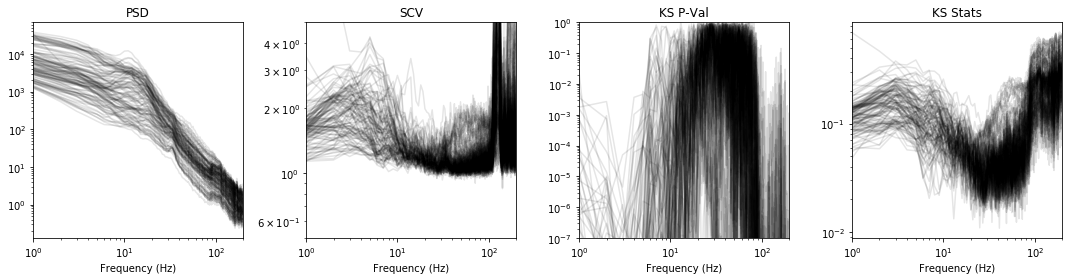

In [7]:
# exponential fits for eyes open/closed transition
plt.figure(figsize=(15,4))
tr_lfpca.plot_spectral(plot_mean=False)

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


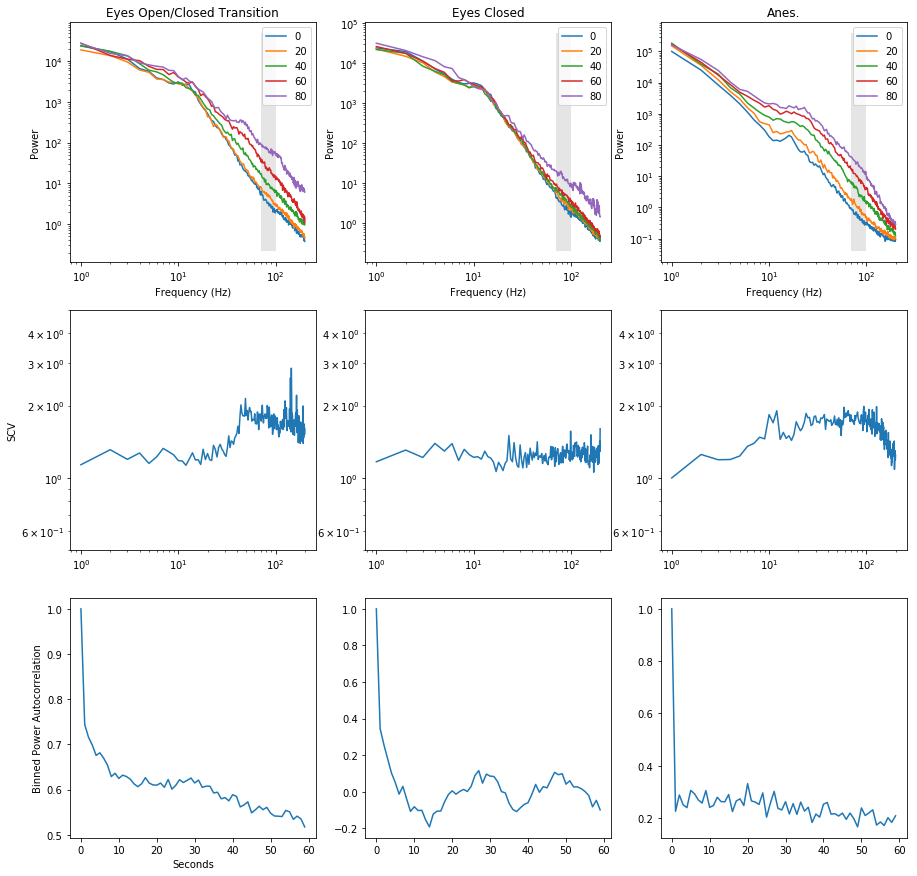

In [18]:
lfpca_viz = [tr_lfpca, ec_lfpca, an_lfpca]
labels = ['Eyes Open/Closed Transition', 'Eyes Closed', 'Anes.']
plot_chan = 78#10,100
rank_freqs=(70,100)
pct=range(0,100,20)
ac_lag = 60
plt.figure(figsize=(15,15))

for i,lf in enumerate(lfpca_viz):
    plt.subplot(3,3,i+1)
    pwr_dgt, _ = utils.percentile_spectrogram(lf.spg[plot_chan,:,:], lf.f_axis, rank_freqs, pct);
    plt.title(labels[i])
    plt.subplot(3,3,i+4)
    plt.loglog(lf.f_axis, lf.scv[plot_chan,:])
    plt.ylim([0.5, 5.])
    plt.subplot(3,3,i+7)
    plt.plot(utils.autocorr(pwr_dgt, ac_lag)[1])

plt.subplot(3,3,4)
plt.ylabel('SCV')
plt.subplot(3,3,7)
plt.xlabel('Seconds')
plt.ylabel('Binned Power Autocorrelation');

### observations: broadband fluctuations under anesthesia
- it appears that there are actually broadband (multi-frequency correlated) power fluctuations under anesthesia in some channels (e.g., 100), which violates the noise exponential null hypothesis, but that is not the case in eyes-closed resting (plotted example channel).
- however, the fluctuation during anesthesia has no autocorrelation in the time domain, which implies that the power fluctuation is stochastic.
- furthermore, some channels have power changes during the eyes open/closed transition (e.g. 90, V1), with occasional prominent oscillatory gamma peak (as shown, channel 20) but some do not.

3 kinds of gammas (channel 10):
- burst oscillatory
- additive (or slope change)
- multiplicative/broadband (poisson rate)


# Example time windows of ranked power

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


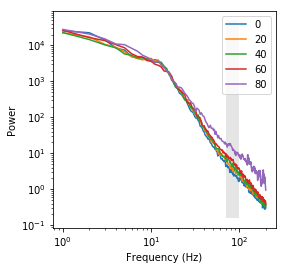

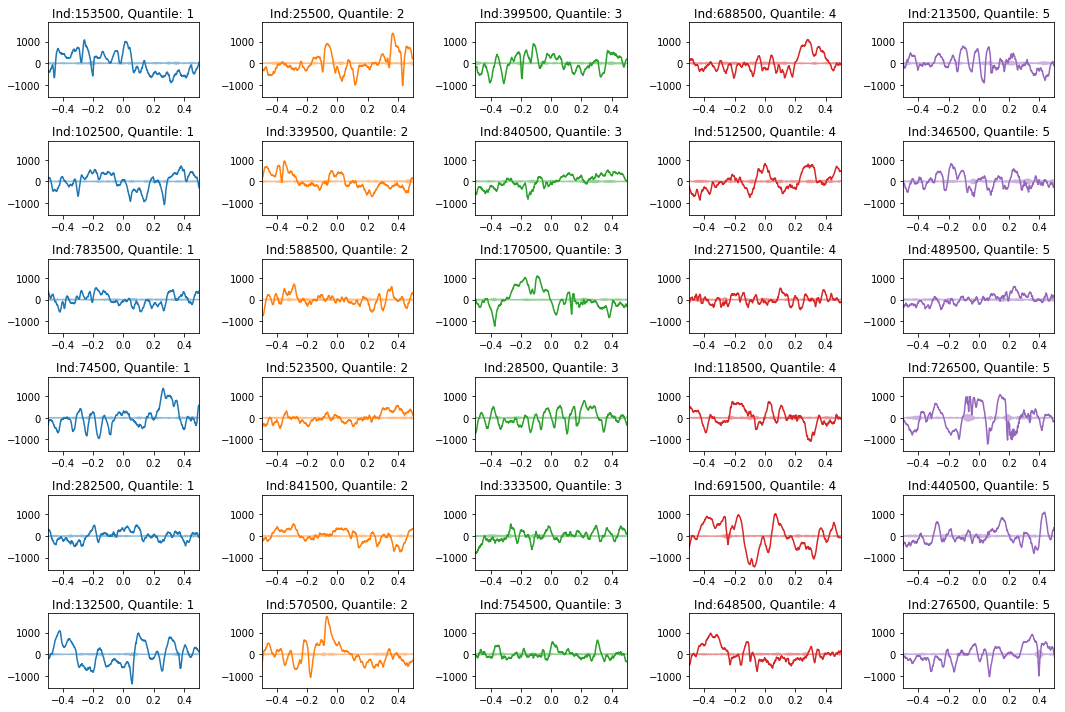

In [25]:
fs = 1000
plot_len = int(fs/2)
plot_chan = 90 #10,100
rank_freqs=(70,100)
pct=range(0,100,20)

lf = ec_lfpca
plt.figure(figsize=(4,4))
pwr_dgt, _ = utils.percentile_spectrogram(lf.spg[plot_chan,:,:], lf.f_axis, rank_freqs, pct);

plt.figure(figsize=(15,10))
utils.plot_power_examples(lf.data[plot_chan,:], lf.fs, lf.t_axis, pwr_dgt, rank_freqs, N_cycles=7, power_adj=2)

### observations: broadband power in time-domain
- During anesthesia, it's unclear, without highpassing the data, what features of the time series correspond to the increase in broadband power. The only prominent observation is that slow & high-amplitude transients (in 1st quantile examples) are anti-correlated with broadband power.
- When plotted along high-passed data, it appears that sharp transients reliably occur around increase in high-frequency power, even if it's very momentarily.
- During eyes open/closed transition, however, broadband power is dominated by ripples.

# Querying SCV of specific channels during state transitions

![Chibi](brainmap-Chibi-v2.jpg)

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


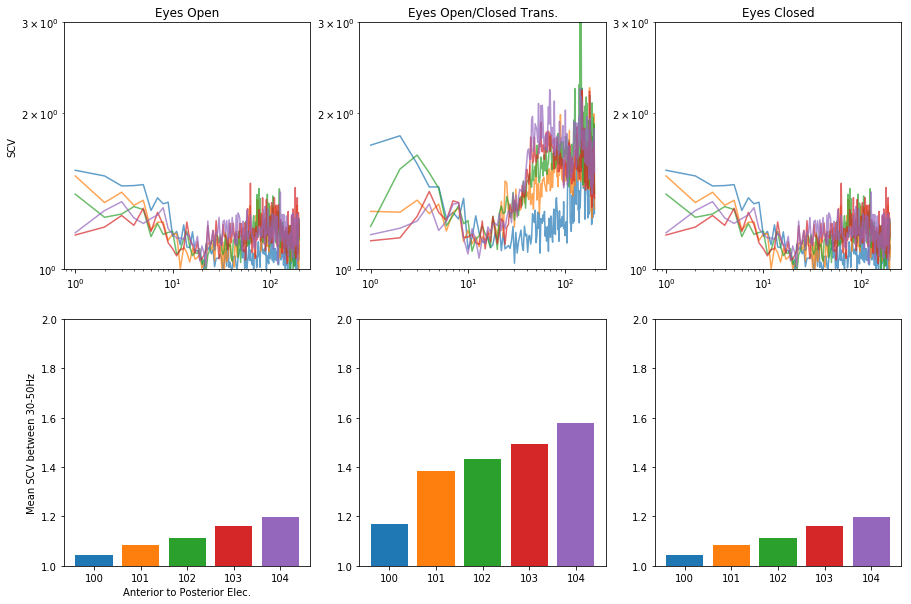

In [140]:
lfpca_viz = [lfpca_all[0], tr_lfpca, lfpca_all[1]]
labels = ['Eyes Open', 'Eyes Open/Closed Trans.', 'Eyes Closed']

noise_freq = [30,50]
noise_inds = tr_lfpca.f_axis[np.logical_and(tr_lfpca.f_axis>noise_freq[0],tr_lfpca.f_axis<noise_freq[1])]

# channels in image starts at 1, so have to minus 1 in index to offset
plot_chans = np.arange(100,105)
#VC: np.arange(87,92) #np.arange(100,105)
#TC: np.arange(68,73) FC: np.arange(45,50)

plt.figure(figsize=(15,10))
for i, lf in enumerate(lfpca_viz):
    plt.subplot(2,3,i+1)
    plt.loglog(lf.f_axis, lf.scv[plot_chans-1,:].T, alpha=0.7)
    plt.ylim([1, 3.])
    plt.title(labels[i])
    plt.subplot(2,3,i+4)
    # geometric mean
    [plt.bar(pc, 10**(np.log10(lf.scv[pc-1][noise_inds.astype(int)]).mean())) for pc in plot_chans]
    plt.ylim([1.,2])

plt.subplot(2,3,1)
plt.ylabel('SCV')
plt.subplot(2,3,4)
plt.xlabel('Anterior to Posterior Elec.')
plt.ylabel('Mean SCV between %i-%iHz'%(noise_freq[0], noise_freq[1]));

### observations: variability along visual hierarchy
- Moving anterior from V1 (91 to 87, 104 to 100), channels have less variability in the "broadband" range (30-100Hz), both during the eyes closed condition and the transition between eyes open to eyes closed, but more variability in low frequency range (1-10Hz)
- No such effect going from PFC to M1 (45 to 51), or along temporal pole (68 to 72) for example

Text(0.5,1,'Anesthesized')

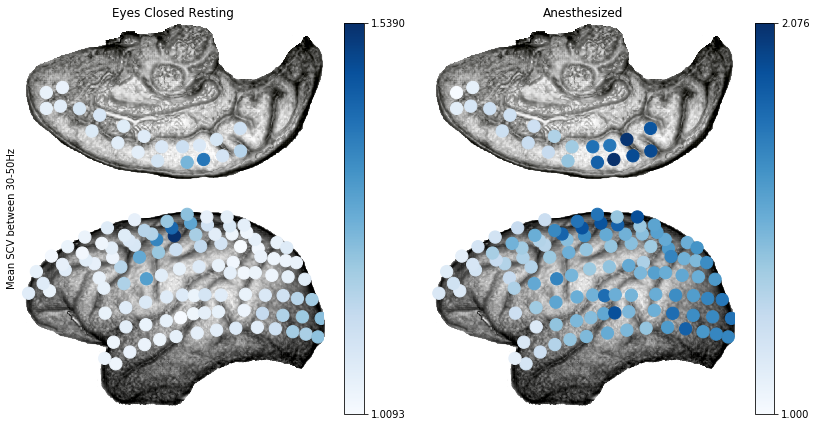

In [16]:
noise_freq = [30,50]
noise_inds = tr_lfpca.f_axis[np.logical_and(tr_lfpca.f_axis>noise_freq[0],tr_lfpca.f_axis<noise_freq[1])]

ctx_file = '/Users/rdgao/documents/Data/NeuroTycho/Propofol/GridLocations/20110621KTMD_Anesthesia+and+Sleep_Chibi_Toru+Yanagawa_mat_2Dimg/ChibiMap.mat'
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
asc.ctx_viz(ctx_file, data=lfpca_all[1].scv[:,noise_inds.astype(int)].mean(axis=1), ms=150.)
plt.ylabel('Mean SCV between %i-%iHz'%(noise_freq[0], noise_freq[1]));
plt.title('Eyes Closed Resting')
plt.subplot(1,2,2)
asc.ctx_viz(ctx_file, data=lfpca_all[2].scv[:,noise_inds.astype(int)].mean(axis=1), ms=150.)
plt.title('Anesthesized')

### observations: spatial topography of noise variability
- During eyes closed resting, variability is almost purely noise-like everywhere (everywhere white), except ~M1 and precuneus.
- Variability in "noise frequency" increases everywhere, but most dramatically in the precuneus region & midline/central sulcus, during anesthesia.